# Simulation Study - Single Area

This is a first simulation study to test the sampler developed in the [`SPMIX`](https://github.com/Teogiane/SPMIX.git) package.

We consider a single area, thus $I = 1$ and $G = 0$, where $G$ is the adjacency matrix. Then, data are simulated from the model as follows:

$$
\newcommand{\iid}{\stackrel{\small\text{iid}}{\sim}}
y_j \iid \sum_{h = 1}^{3} w_h \mathcal{N}\left(\cdot \mid \mu_h, \sigma^2_h\right).
$$

We start by loading the `SPMIX` package. `ggplot` and `repr` are used for visualization.

In [1]:
# Required libraries
library("SPMIX")
library("ggplot2")
library("repr")

Loading required package: RProtoBuf



The following code generate 1000 samples from the above likelihood.

In [2]:
# Generate data (1 location, mixture of 3 normals)
set.seed(230196)
ngroups <- 1; ncomponents <- 3; N <- 1000
means <- c(-4,1,5); std_devs <- c(1,1,1); weights <- matrix(c(1/6,3/6,2/6), ngroups, ncomponents, TRUE)
cluster_alloc <- sample(1:ncomponents, prob = weights, size = N, replace = T)
data <- list(); data[[1]] <- rnorm(N, mean = means[cluster_alloc], sd = std_devs[cluster_alloc])

# Generate Matrix W
W <- matrix(0, nrow = 1, ncol = 1, byrow = T)

Let us show the data:

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


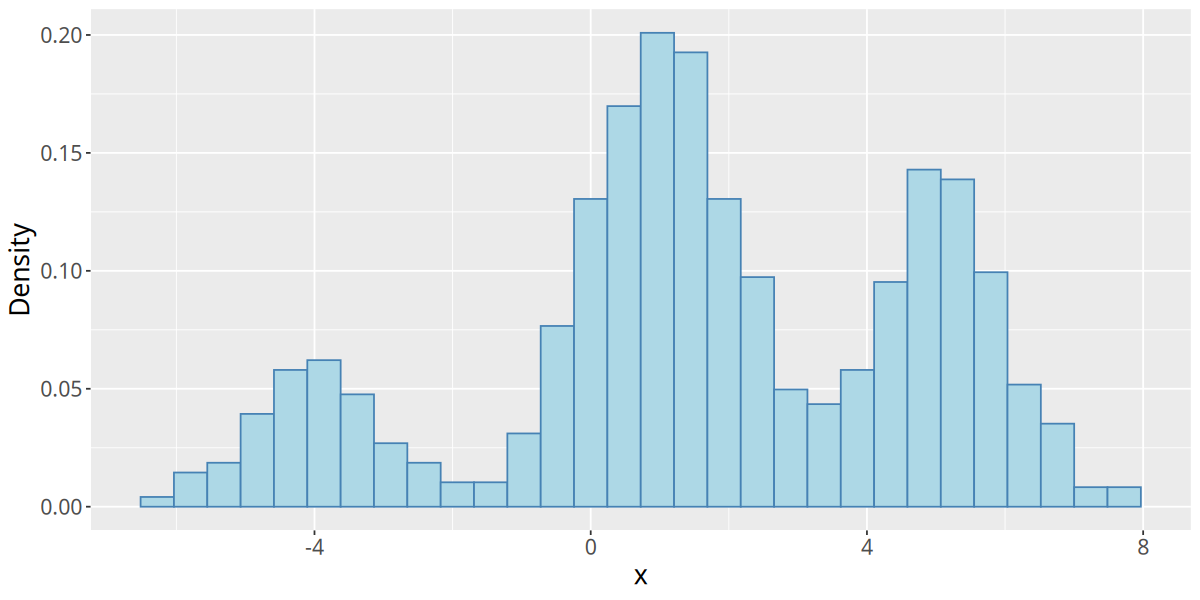

In [3]:
# Generate plot
df = data.frame("x" = data[[1]])
plt_hist <- ggplot() +
    geom_histogram(data = df, aes(x=x, y=..density..), col='steelblue', fill='lightblue', bins = 30) +
    theme(text = element_text(size = 16)) + ylab("Density")

# Show
options(repr.plot.width = 10, repr.plot.height = 5); plt_hist

## Model fit via `SPMIX`

We now fit the data using the `Sampler.DensityEstimation` function in the package. The prior hyperparameters are passed as a path to a `.asciipb` file storing the ASCII representation of a protobuf message of type `SamplerParams`. An example of such file is given within the package and is the one we use here.

In [4]:
# Setting MCMC parameters
burnin = 5000
niter = 5000
thin = 2

# Grab input filenames
params_filename = system.file("input_files/rjsampler_params.asciipb", package = "SPMIX")

# Run Spatial sampler
out <- Sampler.DensityEstimation(burnin, niter, thin, data, W, params_filename, type="rjmcmc")

Data are provided as a list of numeric vectors
Proximity Matrix is provided as a matrix of double
Hyperparameters are provided as a path to an asciipb file
readParamsfromASCII ... done!
Optimization Options required but not given: setting default values ... done!
Init done.



Elapsed Time: 7.63598



## Posterior Inference

### Number of Components
First, we are interested in the posterior distribution of the number of components. Thus, we plot the traceplot of such parameter as well as its posterior distribution.

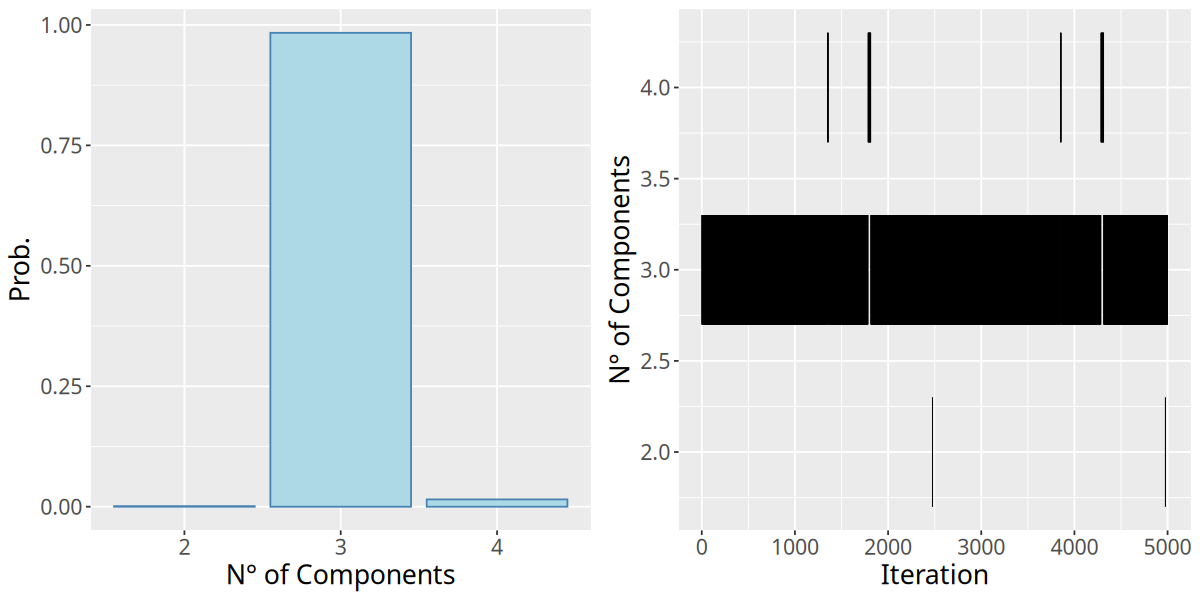

In [5]:
# Deserialization
chains <- sapply(out, function(x) DeserializeSPMIXProto("UnivariateState",x))
H_chain <- sapply(chains, function(x) x$num_components)

# Barplot of the estimated posterior for H
df <- as.data.frame(table(H_chain)/length(H_chain)); names(df) <- c("NumComponents", "Prob.")
plt_postH <- ggplot(data = df, aes(x=NumComponents, y=Prob.)) +
  geom_bar(stat="identity", color="steelblue", fill="lightblue") +
  theme(text = element_text(size = 16)) + xlab("N° of Components")

# Traceplot of H
df <- data.frame("Iteration" = 1:niter, "LowPoints" = H_chain-0.3, "UpPoints" = H_chain+0.3)
plt_traceH <- ggplot(data=df, aes(x=Iteration, y=LowPoints, xend=Iteration, yend=UpPoints)) +
  ylim(range(df[,-1])) + ylab("N° of Components") + geom_segment(linewidth = 0.2) +
  theme(text = element_text(size = 16))
                  
# Show
options(repr.plot.width = 10, repr.plot.height = 5)
gridExtra::grid.arrange(plt_postH, plt_traceH, ncol = 2)

### Density Estimation
We now compute the estimated density we obtain from the chain and compare it with the theoretical one and the empirical density histogram. This is done to assess the quality of the estimation.

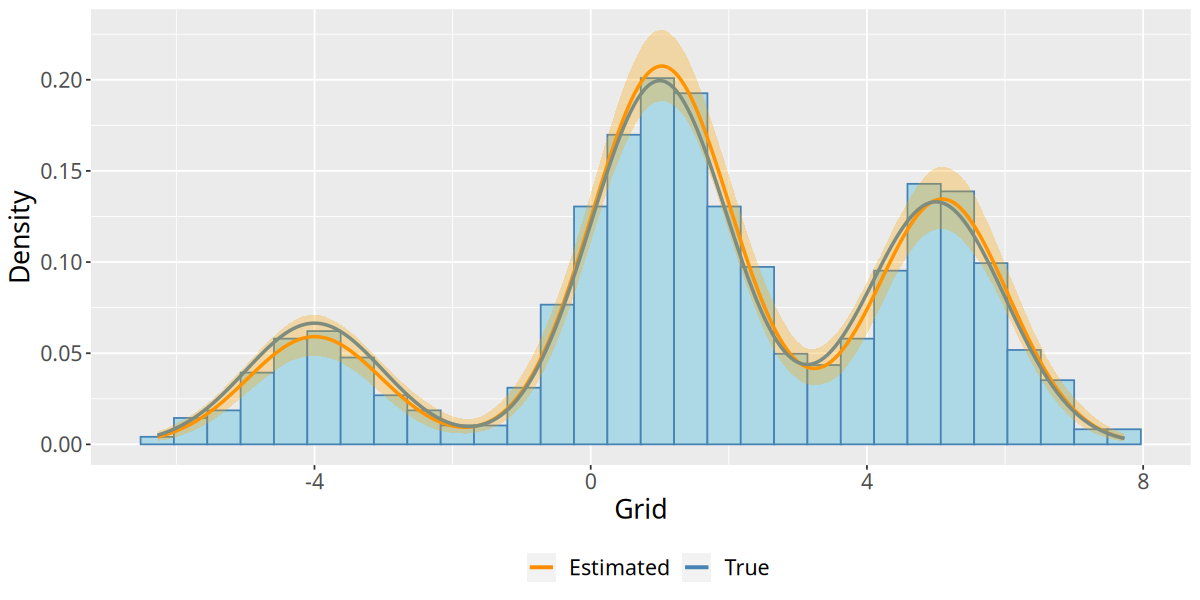

In [6]:
# Compute estimated density
data_ranges <- sapply(data, range); Npoints <- 500
estimated_densities <- ComputeDensities(chains, Npoints, data_ranges, alpha = 0.05)

# Compute true densities
true_densities <- list()
for (i in 1:ngroups) {
  x_grid <- seq(data_ranges[1,i], data_ranges[2,i], length.out = Npoints)
  xgrid_expand <- t(rbind(replicate(ncomponents, x_grid, simplify = "matrix")))
  true_dens <- t(as.matrix(weights[i,])) %*% dnorm(xgrid_expand, means, std_devs)
  true_densities[[i]] <- true_dens
}

# Plot - Density comparison
df1 <- data.frame("x" = data[[1]])
df2 <- data.frame('grid'=seq(data_ranges[1,1], data_ranges[2,1], length.out=Npoints),
                  t(estimated_densities[[1]]),
                  'true'=t(true_densities[[1]]))
# Generate plot
plt_densCompare <- ggplot() +
    geom_histogram(data = df1, aes(x=x, y=..density..), color='steelblue', fill='lightblue', bins = 30) +
    geom_line(data = df2, aes(x=grid, y=est, color="Estimated"), linewidth = 1) +
    geom_line(data = df2, aes(x=grid, y=true, color="True"), linewidth = 1) +
    scale_color_manual("", breaks=c("Estimated","True"), values=c("Estimated"="darkorange", "True"="steelblue")) +
    theme(text = element_text(size = 16), legend.title=element_blank(), legend.position="bottom") +
    xlab("Grid") + ylab("Density")

# Add credibility band if present
if (dim(estimated_densities[[i]])[1] > 1) {
    plt_densCompare <- plt_densCompare + 
        geom_ribbon(data = df2, aes(x=grid, ymax=up, ymin=low), fill="orange", alpha=0.3)
}

# Show
options(repr.plot.width = 10, repr.plot.height = 5); plt_densCompare

### Sensitivity w.r.t. number of observations
We are now interested in how the number of data in a single area may affect the estimation of the number of components $H$. To do so, we fit an increasing number of data sampled from the aformenetioned model. Then, we compare the traceplots for $H$ we obtain.

In [ ]:
# Clean console and set number of observations
rm(list=ls()); set.seed(230196)
Ns <- c(100,250,500,1000)
W <- matrix(0, nrow = 1, ncol = 1, byrow = T)
plots <- list()

# Sampler run loop
for (i in 1:length(Ns)) {
  # Generate data (1 location, mixture of 3 normals)
  ngroups <- 1; ncomponents <- 3; N <- Ns[i]
  means <- c(-4,1,5); std_devs <- c(1,1,1); weights <- c(1/6,3/6,2/6)
  cluster_alloc <- sample(1:ncomponents, prob = weights, size = N, replace = T)
  data <- list(); data[[1]] <- rnorm(N, mean = means[cluster_alloc], sd = std_devs[cluster_alloc])

  # Grab input filenames
  params_filename = system.file("input_files/rjsampler_params.asciipb", package = "SPMIX")

  # Run Spatial sampler
  out <- Sampler.DensityEstimation(0, 10000, 1, data, W, params_filename, type = "rjmcmc")

  # Deserialization
  chains <- sapply(out, function(x) DeserializeSPMIXProto("UnivariateState",x))
  H_chain <- sapply(chains, function(x) x$num_components)

  # Traceplot for the whole chain (no burnin, no thinning)
  df <- data.frame("Iteration"=1:10000, "LowPoints"=H_chain-0.3, "UpPoints"=H_chain+0.3)
  tmp <- ggplot(data=df, aes(x=Iteration, y=LowPoints, xend=Iteration, yend=UpPoints)) +
    ylim(range(df[,-1])) + ylab("N° of Components") + geom_segment(linewidth = 0.1) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5)) +
    ggtitle(paste0("Traceplot of H - ", Ns[i], " obs."))
  rm(list='df')

  # Save plot
  plots[[i]] <- tmp; rm(list='tmp')
}

# Show
options(repr.plot.height = 10, repr.plot.width = 10)
gridExtra::grid.arrange(grobs=plots, nrow=2, ncol=2)